In [1]:
pip install matplotlib seaborn pandas numpy scikit-learn transformers IProgress Flax torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow 

  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached markdown-3.8-py3-none-any.whl.metadata (5.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 MB 18.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 21.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 23.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.8 MB/s eta 0:00:00a 0:00:01
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
Using cached gast-0.6.0-py3-none-any.whl (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 18.8 MB/s eta 0:00:00

In [3]:
pip freeze > req.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import random
import time
from datetime import datetime
from transformers import pipeline
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print("Import successful!")

/Users/bikramjeetdasgupta/Uco Hackathon/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import successful!


In [3]:
class ScamDetector:
    def __init__(self):
        self.classifier = pipeline(
    "text-classification", 
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"  # <- force PyTorch
)
        

    def predict(self, message: str) -> float:
        result = self.classifier(message)[0]
        label = result['label']
        score = result['score']
        return score if label == "POSITIVE" else 1 - score  



In [4]:
class TrustScoreSystem:
    def __init__(self):
        self.scam_detector = ScamDetector()
        self.anomaly_model = IsolationForest(contamination=0.1)
        self.train_anomaly_model()

    def train_anomaly_model(self):
        # Simulated normal user behavior dataset
        normal_data = np.array([
            [50, 2, 14, 0, 60],
            [65, 1, 16, 0, 120],
            [55, 3, 11, 0, 90],
            [40, 4, 13, 0, 80],
        ])
        self.anomaly_model.fit(normal_data)

    def analyze_behavior(self, typing_speed, txn_frequency, access_time, ip_change, session_duration):
        score = 100

        # Raw feature vector for anomaly detection
        hour = datetime.strptime(access_time, "%H:%M").hour
        features = np.array([[typing_speed, txn_frequency, hour, int(ip_change), session_duration]])
        anomaly = self.anomaly_model.predict(features)[0]

        if anomaly == -1:
            score -= 30

        # Traditional rules
        if typing_speed < 20 or typing_speed > 200:
            score -= 10
        if txn_frequency > 10:
            score -= 15
        if hour < 5 or hour > 23:
            score -= 10
        if ip_change:
            score -= 10
        if session_duration < 20:
            score -= 10

        return max(0, score)

    def analyze_notifications(self, notifications):
        if not notifications:
            return 0
        scam_probs = [self.scam_detector.predict(n) for n in notifications]
        max_scam_score = max(scam_probs)
        scam_score = int(max_scam_score * 100)
        return scam_score

    def compute_trust_score(self, behavior_inputs, notifications):
        behavior_score = self.analyze_behavior(**behavior_inputs)
        scam_score = self.analyze_notifications(notifications)

        trust_score = behavior_score - scam_score // 2
        trust_score = max(0, min(100, trust_score))
        return trust_score, behavior_score, scam_score

    def trigger_intervention(self, trust_score):
        if trust_score > 70:
            return "✅ All Clear"
        elif trust_score > 40:
            print("⚠️ Suspected activity. Delaying for 5 seconds...")
            time.sleep(5)
            return "⚠️ Warning: Delayed transaction for confirmation"
        else:
            return "🚫 Blocked: Suspicious activity detected"



In [22]:
def visualize_trust_components(behavior_inputs, scam_score, behavior_score, trust_score):
    labels = ["Typing Speed", "Txn Frequency", "Access Hour", "IP Change", "Session Duration", "Scam Score"]
    hour = datetime.strptime(behavior_inputs["access_time"], "%H:%M").hour
    values = [
        behavior_inputs["typing_speed"],
        behavior_inputs["txn_frequency"],
        hour,
        int(behavior_inputs["ip_change"]),
        behavior_inputs["session_duration"],
        scam_score
    ]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=values, hue=labels, palette="coolwarm", legend=False)
    plt.title(f"Trust Score Breakdown (Final: {trust_score})", fontsize=14)
    plt.ylabel("Feature Value / Score")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [21]:
def visualize_user_heatmap():
    users_data = np.array([
        [50, 2, 14, 0, 60],
        [65, 1, 16, 0, 120],
        [18, 12, 1, 1, 15],  # Suspicious
        [40, 4, 23, 0, 80],
        [22, 9, 2, 1, 30],   # Suspicious
    ])
    feature_labels = ["Typing Speed", "Txn Frequency", "Access Hour", "IP Change", "Session Duration"]

    plt.figure(figsize=(8, 4))
    sns.heatmap(users_data, annot=True, fmt="d", cmap="YlOrRd", xticklabels=feature_labels)
    plt.title("User Behavior Matrix Heatmap")
    plt.xlabel("Behavioral Features")
    plt.ylabel("User Index")
    plt.tight_layout()
    plt.show()



In [7]:
inputs = {
    "typing_speed": 18,
    "txn_frequency": 12,
    "access_time": "01:20",
    "ip_change": True,
    "session_duration": 15
}

notifications = [
    "Your OTP is 395821. Do not share it with anyone",
    "Urgent! Account verification required to avoid suspension"
]

In [9]:
system = TrustScoreSystem()
trust_score, behavior_score, scam_score = system.compute_trust_score(inputs, notifications)
intervention = system.trigger_intervention(trust_score)


Device set to use mps:0



🔢 Trust Score: 13
🔔 Action: 🚫 Blocked: Suspicious activity detected


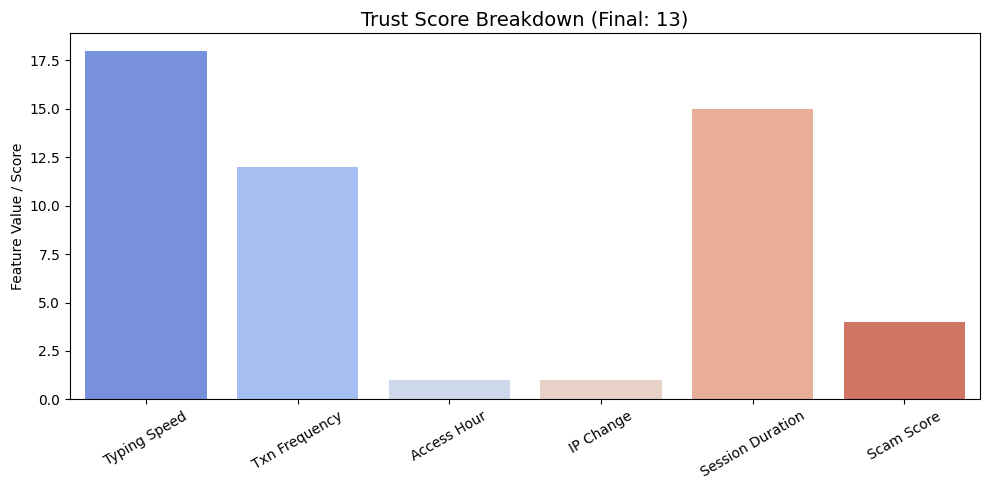

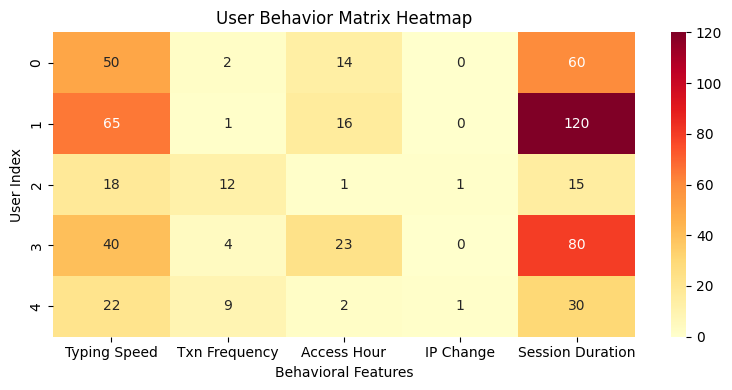

In [23]:
print(f"\n🔢 Trust Score: {trust_score}")
print(f"🔔 Action: {intervention}")

# === Visualize ===
visualize_trust_components(inputs, scam_score, behavior_score, trust_score)
visualize_user_heatmap()